In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
# if using google colab for gpu
!pip install evaluate
!pip install scikit-learn
from google.colab import drive

drive.mount('/content/drive')
path = "drive/MyDrive/yelp_reviews/yelp_academic_dataset_review.json"

In [3]:
# if local
path = "yelp_academic_dataset_review.json"

In [3]:
data = []
with open(path, "r") as f:
    for i, line in enumerate(f):
        if i >= 75000:
            break
        data.append(json.loads(line))
df = pd.DataFrame(data)

In [4]:
review_df = df[['stars', 'text']].astype({'stars': int})
review_df

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...
...,...,...
74995,4,Very cool store!! I've never been to one of th...
74996,5,I have been meaning to write a review for this...
74997,5,This place has MIND-BLOWINGLY good tacos and f...
74998,3,They give you large snowball sizes for little ...


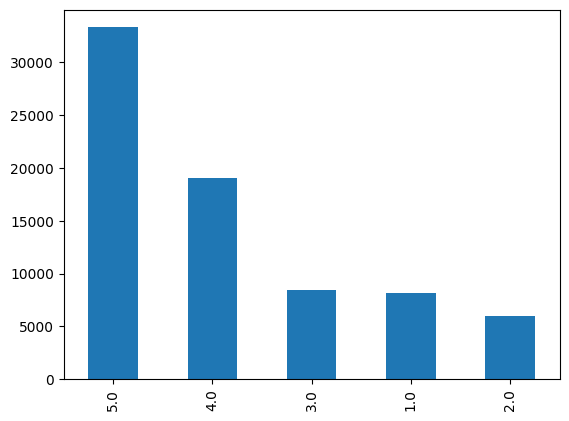

In [5]:
# inspect distribution of classes
df['stars'].value_counts().plot(kind='bar')
plt.show()

In [6]:
# randomly sample from each class based on how many samples the minority class holds
seed = 42
minority_class_count = len(review_df[review_df.loc[:, ('stars')] == 2])
review_df = review_df.groupby('stars').apply(lambda x: x.sample(n=minority_class_count, random_state=seed)).reset_index(drop=True)
review_df

,stars,text
0,1,"I, only gave 1 star because based on the appea..."
1,1,Wouldn't go here again..... I got my belly but...
2,1,Some of the reviews have mentioned how long it...
3,1,"Ok, I hate to give a place one star and I gene..."
4,1,i wish i could have given it a zero or a negat...
...,...,...
29840,5,Great place for drinks (I've never had food he...
29841,5,My girlfriend and I just had a delightful lunc...
29842,5,Gorgeous and stylish. Comfortable and clean. T...
29843,5,Had a great time at BR! Our server Reyna? was ...


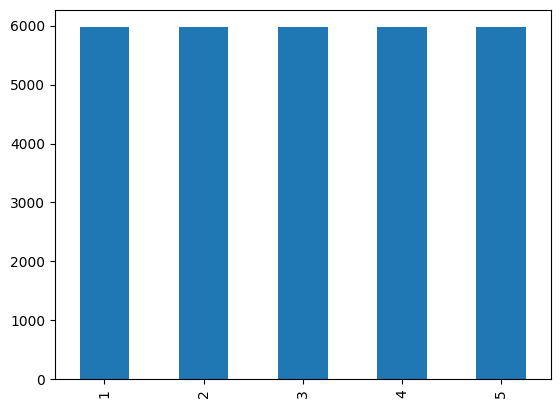

In [7]:
# inspect distribution of classes
review_df['stars'].value_counts().plot(kind='bar')
plt.show()

In [8]:
# transform data into pytorch tensors and tokenize
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoTokenizer
import tqdm
from typing import List

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [9]:
class ReviewDataSet(Dataset):
    """ torch Dataset for our review data """
    def __init__(self, dataframe):
        self.data = self.format_dataset(dataframe)
        self.size = len(dataframe)

    """gives length of dataset"""
    def __len__(self) -> int:
        return self.size

    """function allows object to be subscriptable -> dataset[0]"""
    def __getitem__(self, idx: int):
        label = self.data['labels'][idx]
        input_ids = self.data['input_ids'][idx]
        token_type = self.data['token_type_ids'][idx]
        att_mask = self.data['attention_mask'][idx]
        sample = {'labels': label, 'input_ids': input_ids, 'token_type_ids': token_type, 'attention_mask': att_mask}
        return sample


    def tokenize_text(self, text_data):
        token_dict = tokenizer(text_data, padding='max_length', truncation=True)
        input = torch.tensor(token_dict['input_ids'])
        token_type = torch.tensor(token_dict['token_type_ids'])
        att_mask = torch.tensor(token_dict['attention_mask'])
        return input, token_type, att_mask

    def format_dataset(self, dataframe: pd.DataFrame):
        self.data = {}
        input, token_type, att_mask = zip(*dataframe['text'].apply(self.tokenize_text))
        self.data['labels'] = torch.tensor(dataframe['stars'].to_list())-1
        self.data['input_ids'] = input
        self.data['token_type_ids'] = token_type
        self.data['attention_mask'] = att_mask
        return self.data


In [10]:
review_dataset = ReviewDataSet(review_df)

In [ ]:
# input for DataLoader needs to implement __getitem__() and __len__()
print(len(review_dataset))
print(review_dataset[0])

In [28]:
# train and val split
train_size = int(0.8 * len(review_dataset))
val_size = len(review_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(review_dataset, [train_size, val_size], generator)
print(f'train and validation dataset sizes: {len(train_dataset), len(val_dataset)}')


train and validation dataset sizes: (23876, 5969)


In [13]:
# dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [14]:
# load model, optimizer and scheduler
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler

In [15]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=5)
optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 3
train_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name='linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=train_steps)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
model.to(device)

In [17]:
device

device(type='cuda')

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained("drive/MyDrive/yelp_reviews/bert_model")
# model.to(device)

In [25]:
import evaluate

def should_run_eval(total_steps, freq, current_step):
    return current_step % (total_steps // freq) == 0

def eval(model, val_data):
    # TODO: add some kind of confusion matrix
    pbar = tqdm(range(len(val_data)))
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in val_data:
        batch = {
            "input_ids": batch["input_ids"].to(model.device),
            "labels": batch["labels"].to(model.device),
            "attention_mask": batch["attention_mask"].to(model.device),
        }
        with torch.no_grad():
            outputs = model(**batch)

        # compute loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        metric.add_batch(predictions=preds, references=batch["labels"])
        pbar.update(1)
    acc_result = metric.compute()
    print(f"Accuracy: {acc_result['accuracy']}")

def save_model(model, outpath, current_epoch, current_step):
    print(f"saving model at epoch: {current_epoch}, step: {current_step}")
    outpath += f"/epoch_{current_epoch}/step_{current_step}"
    model.save_pretrained(outpath)

In [ ]:
from tqdm.auto import tqdm
import uuid

pbar = tqdm(range(train_steps))

#train loop
run_id = str(uuid.uuid4())
output_dir = f"./outputs/bert/{run_id}"
model.train()
for epoch in range(epochs):
    current_epoch = epoch + 1

    for step, batch in enumerate(train_dataloader):
        current_step = step + 1
        pbar.set_description(f"Epoch {current_epoch} :: Step {current_step}")

        batch = {
            "input_ids": batch["input_ids"].to(model.device),
            "labels": batch["labels"].to(model.device),
            "attention_mask": batch["attention_mask"].to(model.device),
        }

        # forward
        outputs = model(**batch)

        loss = outputs.loss

        # backward
        loss.backward()

        # update weights
        optimizer.step()
        lr_scheduler.step()

        # evaluate and save model
        if should_run_eval(len(train_dataloader), 2, current_step):
            eval(model, val_dataloader)
            save_model(model, output_dir, current_epoch, current_step)
            model.train()
        pbar.update(1)

save_model(model, tokenizer, output_dir, current_epoch, "final")



In [26]:
eval(model, val_dataloader)

  0%|          | 0/374 [00:00<?, ?it/s]

EVALUATING...
EVAL COMPLETE
Accuracy: 0.8083431060479143
